### Script to process medical CT images 

In [85]:
import os
import numpy as np
import SimpleITK as sitk

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from typing import List, Tuple, Dict, Union 

import pydicom


### Color maps 

In [86]:

def define_color_maps() -> Tuple[List[List[float]], List[List[float]], List[List[float]]]:
    """
    Define color maps 'colmap', 'colmap2', and 'clm'.

    Returns:
        Tuple containing the three color maps.
    """
    # First color map (colmap)
    colmap = [
        [0.95686275, 0.89803922, 0.83921569],
        [0.95294118, 0.89411765, 0.82745098],
        # Additional entries can be added here
    ]
    
    # Second color map (colmap2)
    colmap2 = [
        [0.79607843, 0.79607843, 0.79607843],
        [0.77647059, 0.77647059, 0.77647059],
        # Additional entries can be added here
    ]
    
    # Third color map (clm)
    clm = [
        [0.93387425, 0.78782964, 0.43488845],
        [0.93346858, 0.77931035, 0.40676132],
        # Additional entries can be added here
    ]
    
    return colmap, colmap2, clm

# Example usage
colmap, colmap2, clm = define_color_maps()
print("Color Map 1 (colmap):", colmap[:2])
print("Color Map 2 (colmap2):", colmap2[:2])
print("Color Map 3 (clm):", clm[:2])

Color Map 1 (colmap): [[0.95686275, 0.89803922, 0.83921569], [0.95294118, 0.89411765, 0.82745098]]
Color Map 2 (colmap2): [[0.79607843, 0.79607843, 0.79607843], [0.77647059, 0.77647059, 0.77647059]]
Color Map 3 (clm): [[0.93387425, 0.78782964, 0.43488845], [0.93346858, 0.77931035, 0.40676132]]


### Define directories to process and input parameters 

In [87]:

exp = 'exp2_ss'

input_parameters = {
    'plottype': 'whole',
    'CT_water': 0,
    'CT_air': -1000,
    'coarse': 8,
    'rockin': 1,#16,
    'rockout': 207,#192,
    'num_slices': 208,
    'Slicethick': 0.625,
    'Voxsize': 0.1875,
    'cx_in': 289, #centering correction for inlet 
    'cy_in': 233,
    'cr': 119, #radius of core
    'cx_out': 279, #centering correction for outlet 
    'cy_out': 242
}


### Loading directory and centering parameters

In [88]:

def get_folder_names(exp: str) -> List[str]:
    #Retrieve the names of the folders for the given experiment.
    def list_all_folders(exp_path: str) -> List[str]:
    #List all folders within the experiment path.
        return [f.name for f in os.scandir(exp_path) if f.is_dir()]

    exp_path = os.path.join("E:\\Medical_CT\\", exp)
    folder_names = list_all_folders(exp_path)
    return folder_names, exp_path


def calculate_center_points(input_parameters: Dict[str, float]) -> Tuple[List[int], List[int]]:
    """
    Calculate moving center points using given slopes.

    Args:
        input_parameters (Dict[str, float]): Dictionary containing the input parameters.
        num_slices (int): Number of slices.

    Returns:
        Tuple[List[int], List[int]]: Tuple containing lists of x and y center points.
    """
    slope_cx = (input_parameters['cx_in'] - input_parameters['cx_out']) / (input_parameters['num_slices'] - 1)
    Intpt_cx = input_parameters['cx_out'] - slope_cx
    slope_cy = (input_parameters['cy_in'] - input_parameters['cy_out']) / (input_parameters['num_slices'] - 1)
    Intpt_cy = input_parameters['cy_out'] - slope_cy

    cx = [round(slope_cx * i + Intpt_cx) for i in range(1, input_parameters['num_slices'] + 1)]
    cy = [round(slope_cy * i + Intpt_cy) for i in range(1, input_parameters['num_slices'] + 1)]
    
    return cx, cy





### Read in dicom files 

In [89]:

def load_process_scan(path_to_files: List[str], folder_name: List[str], cx_list: List[int], cy_list: List[int], cr: int) -> Tuple[np.ndarray, List[float]]:
    """
    Process flow scans by reading DICOM files, averaging, masking, reorienting, and calculating CT numbers.

    Args:
        file_paths (List[str]): List of file paths to the DICOM files.
        cx_list (List[int]): List of center x-coordinates.
        cy_list (List[int]): List of center y-coordinates.
        cr (int): Radius for masking.

    Returns:
        Tuple[np.ndarray, List[float]]: Tuple containing the processed 3D image array and slice-averaged CT numbers.
    """
    def read_dicom_file(file_path: str) -> np.ndarray:
        #Read a DICOM file from the given path
        dicom_file = pydicom.dcmread(file_path, force = "True")
        dicom_file.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian  # or whatever is the correct transfer syntax for the file
        return dicom_file.pixel_array.astype(float)

    
    def center_rock_sample(image: np.ndarray, cx: int, cy: int, cr: int) -> np.ndarray:
        #centering correction 
        nr, nc = image.shape
        xx, yy = np.meshgrid(range(1, nr + 1), range(1, nc + 1), indexing='ij')
        c_mask = ((xx - cx) ** 2 + (yy - cy) ** 2 <= cr ** 2)
        dummy = np.ones_like(image)
        dummy *= c_mask
        dummy[dummy == 0] = np.nan
        centered_image = image * dummy
        return centered_image

    #change directory to one of interest 
    os.chdir(os.path.join(path_to_files, folder_name))
    image_names = os.listdir()
    images_to_process = image_names[:input_parameters['num_slices']]

    processed_images = []
    ct_numbers = []
    for kk, file_path in enumerate(images_to_process):
        cx, cy = cx_list[kk], cy_list[kk]
        image = read_dicom_file(file_path)
        centered_image = center_rock_sample(image, cx, cy, cr)
        processed_images.append(centered_image)
        ct_number = np.nanmean(centered_image)
        ct_numbers.append(ct_number)

    print(folder_name)
    return np.array(processed_images), ct_numbers

folder_names, path_to_files = get_folder_names(exp)

cx_list, cy_list = calculate_center_points(input_parameters)
processed_images, ct_numbers = load_process_scan(path_to_files, folder_names[5], cx_list, cy_list, cr = input_parameters['cr'])
processed_images_wet, ct_numbers_wet = load_process_scan(path_to_files, "wet", cx_list, cy_list, cr = input_parameters['cr'])
processed_images_dry, ct_numbers_dry = load_process_scan("E:\\Medical_CT\\", "dry_indiana_initial_pos", cx_list, cy_list, cr = input_parameters['cr'])


print("Processed Images Shape:", processed_images.shape)
print("CT Numbers:", ct_numbers)

print("Processed Images Shape:", processed_images_wet.shape)
print("CT Numbers:", ct_numbers_wet)

print("Processed Images Shape:", processed_images_dry.shape)
print("CT Numbers:", ct_numbers_dry)

post_drain
wet
dry_indiana_initial_pos
Processed Images Shape: (208, 512, 512)
CT Numbers: [3702.5168994130745, 3667.9532483302974, 3674.797184555533, 3683.8545953360767, 3678.4421057365807, 3687.895927500056, 3690.3011761002044, 3679.0537902808696, 3491.6706694551262, 2760.0457622163754, 2548.4111853201107, 2505.8212687490163, 2477.9982909442533, 3275.5059254761745, 3363.8667386269085, 3376.7417976567945, 3349.755537565495, 3346.969034608379, 3333.773032899323, 3327.4691807776203, 3318.8936787424946, 3321.409881040725, 3318.9658638602173, 3317.0931210506196, 3320.8242820841483, 3323.3511659807955, 3326.15536665992, 3323.1671951246935, 3325.1787312509837, 3325.222222222222, 3323.887697047381, 3323.826103577773, 3319.1619105444242, 3323.8185477523666, 3321.760035080618, 3322.675346870854, 3317.5897366704894, 3320.908430592098, 3318.983269243743, 3318.8439362252357, 3318.9109042254154, 3320.758865726686, 3320.8732825114125, 3316.929074186512, 3330.033146686456, 3335.3115428725628, 3338.5

### Calculating porosity/saturation 

Slice-Averaged porosity: 206


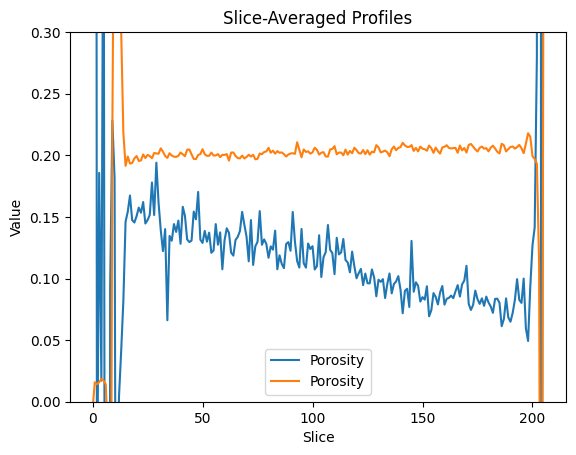

In [90]:


def apply_coarsening(image: np.ndarray, coarse: int) -> np.ndarray:
    # Reshape the image to apply coarsening
    shape = (image.shape[0] // coarse, coarse, image.shape[1] // coarse, coarse)
    coarsened_image = image.reshape(shape).mean(-1).mean(1)
    return coarsened_image

def calculate_porosity(image_dry: np.ndarray, image_wet: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """

    images_porosity              = (image_wet - image_dry) / (CT_water - CT_air) 
    voxel_porosity_coarsened     = [apply_coarsening(image, coarse) for image in images_porosity]
    slice_averaged_porosity      = [np.nanmean(image) for image in voxel_porosity_coarsened]
    core_averaged_porosity       = np.nanmean(slice_averaged_porosity[rockin:rockout])
    voxel_porosity_coarsened     = np.array(voxel_porosity_coarsened)
    return voxel_porosity_coarsened[rockin:rockout, ...], core_averaged_porosity, slice_averaged_porosity[rockin:rockout] 


def calculate_saturation(image_flow: np.ndarray, image_wet: np.ndarray, porosity: np.ndarray, CT_water: float, CT_air: float, coarse: int, rockin: int, rockout: int) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Perform porosity calculations by calculating 2D porosity, applying coarsening, computing 3D porosity, and calculating slice-averaged porosity.

    Args:
        images (np.ndarray): Array containing the images.
        CT_water (float): CT number for water.
        CT_air (float): CT number for air.
        coarse (int): Coarsening factor.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float]]: Tuple containing 2D porosity array, 3D porosity array, and slice-averaged porosity.
    """


    images_sat              = (image_wet - image_flow) / (CT_water - CT_air) 
    voxel_sat_coarsened     = [apply_coarsening(image, coarse) for image in images_sat]
    voxel_sat_coarsened     = np.array(voxel_sat_coarsened)
    voxel_sat_coarsened     = voxel_sat_coarsened[rockin:rockout, ...] / porosity
    slice_averaged_sat      = [np.nanmean(image) for image in voxel_sat_coarsened]
    core_averaged_sat       = np.nanmean(slice_averaged_sat)
    return voxel_sat_coarsened, core_averaged_sat, slice_averaged_sat

# Example usage
CT_water = input_parameters['CT_water']
CT_air = input_parameters['CT_air']
coarse = input_parameters['coarse']
rockin = input_parameters['rockin']
rockout = input_parameters['rockout']

porosity_voxels, core_averaged_porosity, slice_averaged_porosity = calculate_porosity(processed_images_dry, processed_images_wet, CT_water, CT_air, coarse, rockin, rockout)
saturation_voxels, core_averaged_sat, slice_averaged_sat = calculate_saturation(processed_images, processed_images_wet, porosity_voxels, CT_water, CT_air, coarse, rockin, rockout)


print("Slice-Averaged porosity:", len(slice_averaged_porosity))


def plot_slice_averaged_profiles(slice_averaged: List[float], ct_numbers: List[float]) -> None:
    """
    Plot slice-averaged profiles for porosity and CT numbers.

    Args:
        slice_averaged_porosity (List[float]): Slice-averaged porosity values.
        ct_numbers (List[float]): CT numbers for the slices.
    """
    plt.plot(slice_averaged, label="Porosity")
    plt.ylim(0, 0.3)
    plt.legend()
    plt.title("Slice-Averaged Profiles")
    plt.xlabel("Slice")
    plt.ylabel("Value")

plot_slice_averaged_profiles(slice_averaged_sat, ct_numbers)
plot_slice_averaged_profiles(slice_averaged_porosity, ct_numbers_dry)
plt.show()


In [93]:
x = saturation_voxels  # your data



def plot_voxels(down_sample_rate=1, alpha=1.0, slice_dim=None, slice_pos=0, azimuth=90):
    plt.close()
    
    v_min = 0
    v_max = 0.3
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x_downsampled = x[::down_sample_rate, ::down_sample_rate, ::down_sample_rate]
    
    if slice_dim is None:
        i, j, k = np.where(x_downsampled >= -np.inf)
        color_data = x_downsampled[i, j, k]
    else:
        if slice_dim == 'x':
            i = np.array([slice_pos] * x_downsampled.shape[1] * x_downsampled.shape[2])
            j, k = np.meshgrid(np.arange(x_downsampled.shape[1]), np.arange(x_downsampled.shape[2]))
        elif slice_dim == 'y':
            j = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[2])
            i, k = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[2]))
        elif slice_dim == 'z':
            k = np.array([slice_pos] * x_downsampled.shape[0] * x_downsampled.shape[1])
            i, j = np.meshgrid(np.arange(x_downsampled.shape[0]), np.arange(x_downsampled.shape[1]))
        
        i, j, k = i.flatten(), j.flatten(), k.flatten()
        color_data = x_downsampled[i, j, k]
    
    sc = ax.scatter(i, j, k, c=color_data, cmap='viridis', marker='s', vmin=v_min, vmax=v_max, alpha=alpha)
    
    ax.view_init(azim=azimuth)

    ax.set_xlim([0, x_downsampled.shape[0]])
    ax.set_ylim([0, x_downsampled.shape[1]])
    ax.set_zlim([0, x_downsampled.shape[2]])
    
    plt.colorbar(sc)
    plt.show()


down_sample_rate_widget = IntSlider(min=1, max=5, step=1, value=1, description='Downsample Rate:')
alpha_widget = FloatSlider(min=0, max=1, step=0.1, value=1, description='Opacity:')
slice_dim_widget = Dropdown(options=[None, 'x', 'y', 'z'], value=None, description='Slice Dimension:')
slice_pos_widget = IntSlider(min=0, max=x.shape[0] - 1, step=1, value=0, description='Slice Position:')
azimuth_widget = IntSlider(min=0, max=360, step=1, value=90, description='Azimuth:')

interact(
    plot_voxels,
    down_sample_rate=down_sample_rate_widget,
    alpha=alpha_widget,
    slice_dim=slice_dim_widget,
    slice_pos=slice_pos_widget,
)

interactive(children=(IntSlider(value=1, description='Downsample Rate:', max=5, min=1), FloatSlider(value=1.0,…

<function __main__.plot_voxels(down_sample_rate=1, alpha=1.0, slice_dim=None, slice_pos=0, azimuth=90)>